#서론

image Text recognization은 최근 각광받고 있는 분야 중 하나이다. 특히 Google, papago 등은 최근에 이미지를 입력하면 곧 바로 내가 원하는 언어로 번역하는 실시간 이미지 번역 서비스를 소개했다.

image Text recognization은 보통 크게 두가지로 나누어지는데,text detection 그리고 text recognization으로 나누어진다. text detection은 이미지에서 text가 있는 곳을 특정하는 방법이고, 그 후 text recognization을 통해 특정한 부분을 단어들과 매칭시켜서 번역하는 작업이 필요하다. 
그리고 이런 모든 과정 전에 image preprocessing은 필수적이다. 
image preprocessing에는 여러가지 다양한 방법이 있는데, 가장 많이 쓰이는 방법은 image to binary 에 대한 threshold 조정이다 그러나 나는 이 방법보다 더 이미지의 특징을 잘 잡아내는 방법이 있을까 고민하다가 수직, 수평, 그리고 색상 분포를 이용해 조금 더 이미지의 특징을 잘 잡아낼 수 있지 않을까 하는 의문을 가지게 되었다. 

hypothesis: 아무것도 전처리를 하지 않은 데이터보다 수직, 수평, 혹은 이진변환을 이용한 preprocessing이 적용된 데이터에 대한 모델의 학습 정확도가 더 높을 것이다.

In [24]:
import os
import cv2
import numpy as np
import scipy.ndimage as nd
from random import randint
import random

import matplotlib.pyplot as plt

import imageio
from skimage.io import imread_collection
from skimage.transform import resize
from skimage import color, io
from skimage.exposure import rescale_intensity
from keras.callbacks import ModelCheckpoint

In [2]:
def get_data(dirname):
    im_list=[]
    label=[]
    d_list=['buildings','forest','glacier','mountain','sea','street']
    for dl in d_list: 
        i_c=imread_collection(("""./dataset/{}/{}/{}/*.jpg""".format(dirname,dirname,dl)))
        for i in i_c:
            im_list.append(resize(i,(150,150,3)))
            label.append(get_LE(dl))
        print("""./dataset/{}/{}/{} download completed""".format(dirname,dirname,dl))
    im_list=np.array(im_list)
    print(im_list.shape)    
    return np.array(im_list),np.array(label)

def get_pred_data(dirname):
    im_list=[]
    label=[]
    i_c=imread_collection(("""./dataset/{}/{}/*.jpg""".format(dirname,dirname,dl)))
    for i in i_c:
        im_list.append(resize(i,(150,150,3)))
        label.append(get_LE(dl))
    print("""./dataset/{}/{} download completed""".format(dirname,dirname))
    im_list=np.array(im_list)
    print(im_list.shape)    
    return np.array(im_list),np.array(label)

def get_LE(class_code):
    labels = {'glacier':2, 'sea':4, 'buildings':0, 'forest':1, 'street':5, 'mountain':3}
    lst=np.zeros((6,))
    lst[labels[class_code]]=1
    return lst
def get_L(l_list):
    labels = {2:'glacier', 4:'sea', 0:'buildings', 1:'forest',5:'street',3:'mountain'}
    for i,lt in enumerate(l_list):
        if lt ==1 :
            return labels[i]
    return 'Wrong index'

In [3]:
def show_acc(history):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']

    loss = history.history['loss']
    val_loss = history.history['val_loss']

    epochs_range = range(epochs)

    plt.figure(figsize=(16, 8))
    plt.subplot(1, 2, 1)
    plt.plot(epochs_range, acc, label='Training Accuracy')
    plt.plot(epochs_range, val_acc, label='Validation Accuracy')
    plt.legend(loc='lower right')
    plt.title('Training and Validation Accuracy')

    plt.subplot(1, 2, 2)
    plt.plot(epochs_range, loss, label='Training Loss')
    plt.plot(epochs_range, val_loss, label='Validation Loss')
    plt.legend(loc='upper right')
    plt.title('Training and Validation Loss')
    plt.show()

In [9]:
np.warnings.filterwarnings('ignore', category=np.VisibleDeprecationWarning)
X_train,y_train=get_data('seg_train')

./dataset/seg_train/seg_train/buildings download completed
./dataset/seg_train/seg_train/forest download completed
./dataset/seg_train/seg_train/glacier download completed
./dataset/seg_train/seg_train/mountain download completed
./dataset/seg_train/seg_train/sea download completed
./dataset/seg_train/seg_train/street download completed
(14034, 150, 150, 3)


In [5]:
X_test,y_test=get_data('seg_test')

./dataset/seg_test/seg_test/buildings download completed
./dataset/seg_test/seg_test/forest download completed
./dataset/seg_test/seg_test/glacier download completed
./dataset/seg_test/seg_test/mountain download completed
./dataset/seg_test/seg_test/sea download completed
./dataset/seg_test/seg_test/street download completed
(3000, 150, 150, 3)


In [10]:
random.seed(10)
def shuffle_split_data(X, y):
    arr_rand = np.random.rand(X.shape[0])
    split = arr_rand < np.percentile(arr_rand, 70)

    X_tn = X[split]
    y_tn = y[split]
    X_tt =  X[~split]
    y_tt = y[~split]

    print(len(X_tn), len(y_tn), len(X_tt), len(y_tt))
    return X_tn, y_tn, X_tt, y_tt

X_train,y_train,X_val,y_val=shuffle_split_data(X_train,y_train)

9824 9824 4210 4210


In [62]:
horizontal_edge_convolution = np.array([[1,1,1,1,],
                                        [0,0,0,0],
                                        [0,0,0,0],
                                        [-1,-1,-1,-1]])

vertical_edge_convolution = np.array([[1, 0, 0, 0, -1],
                                     [1, 0, 0, 0, -1],
                                     [1, 0, 0, 0, -1],
                                     [1, 0, 0, 0, -1],
                                     [1, 0, 0, 0, -1]])
def get_vertical_features(check):
    check_grayscale = rescale_intensity(color.rgb2gray(check))
    check_edges_vert = nd.convolve(check_grayscale, vertical_edge_convolution, mode='constant', cval=0.0)
    return check_edges_vert

def get_horizontal_features(check):
    check_grayscale = rescale_intensity(color.rgb2gray(check))
    check_edges_horz = nd.convolve(check_grayscale, horizontal_edge_convolution, mode='reflect')
    return check_edges_horz

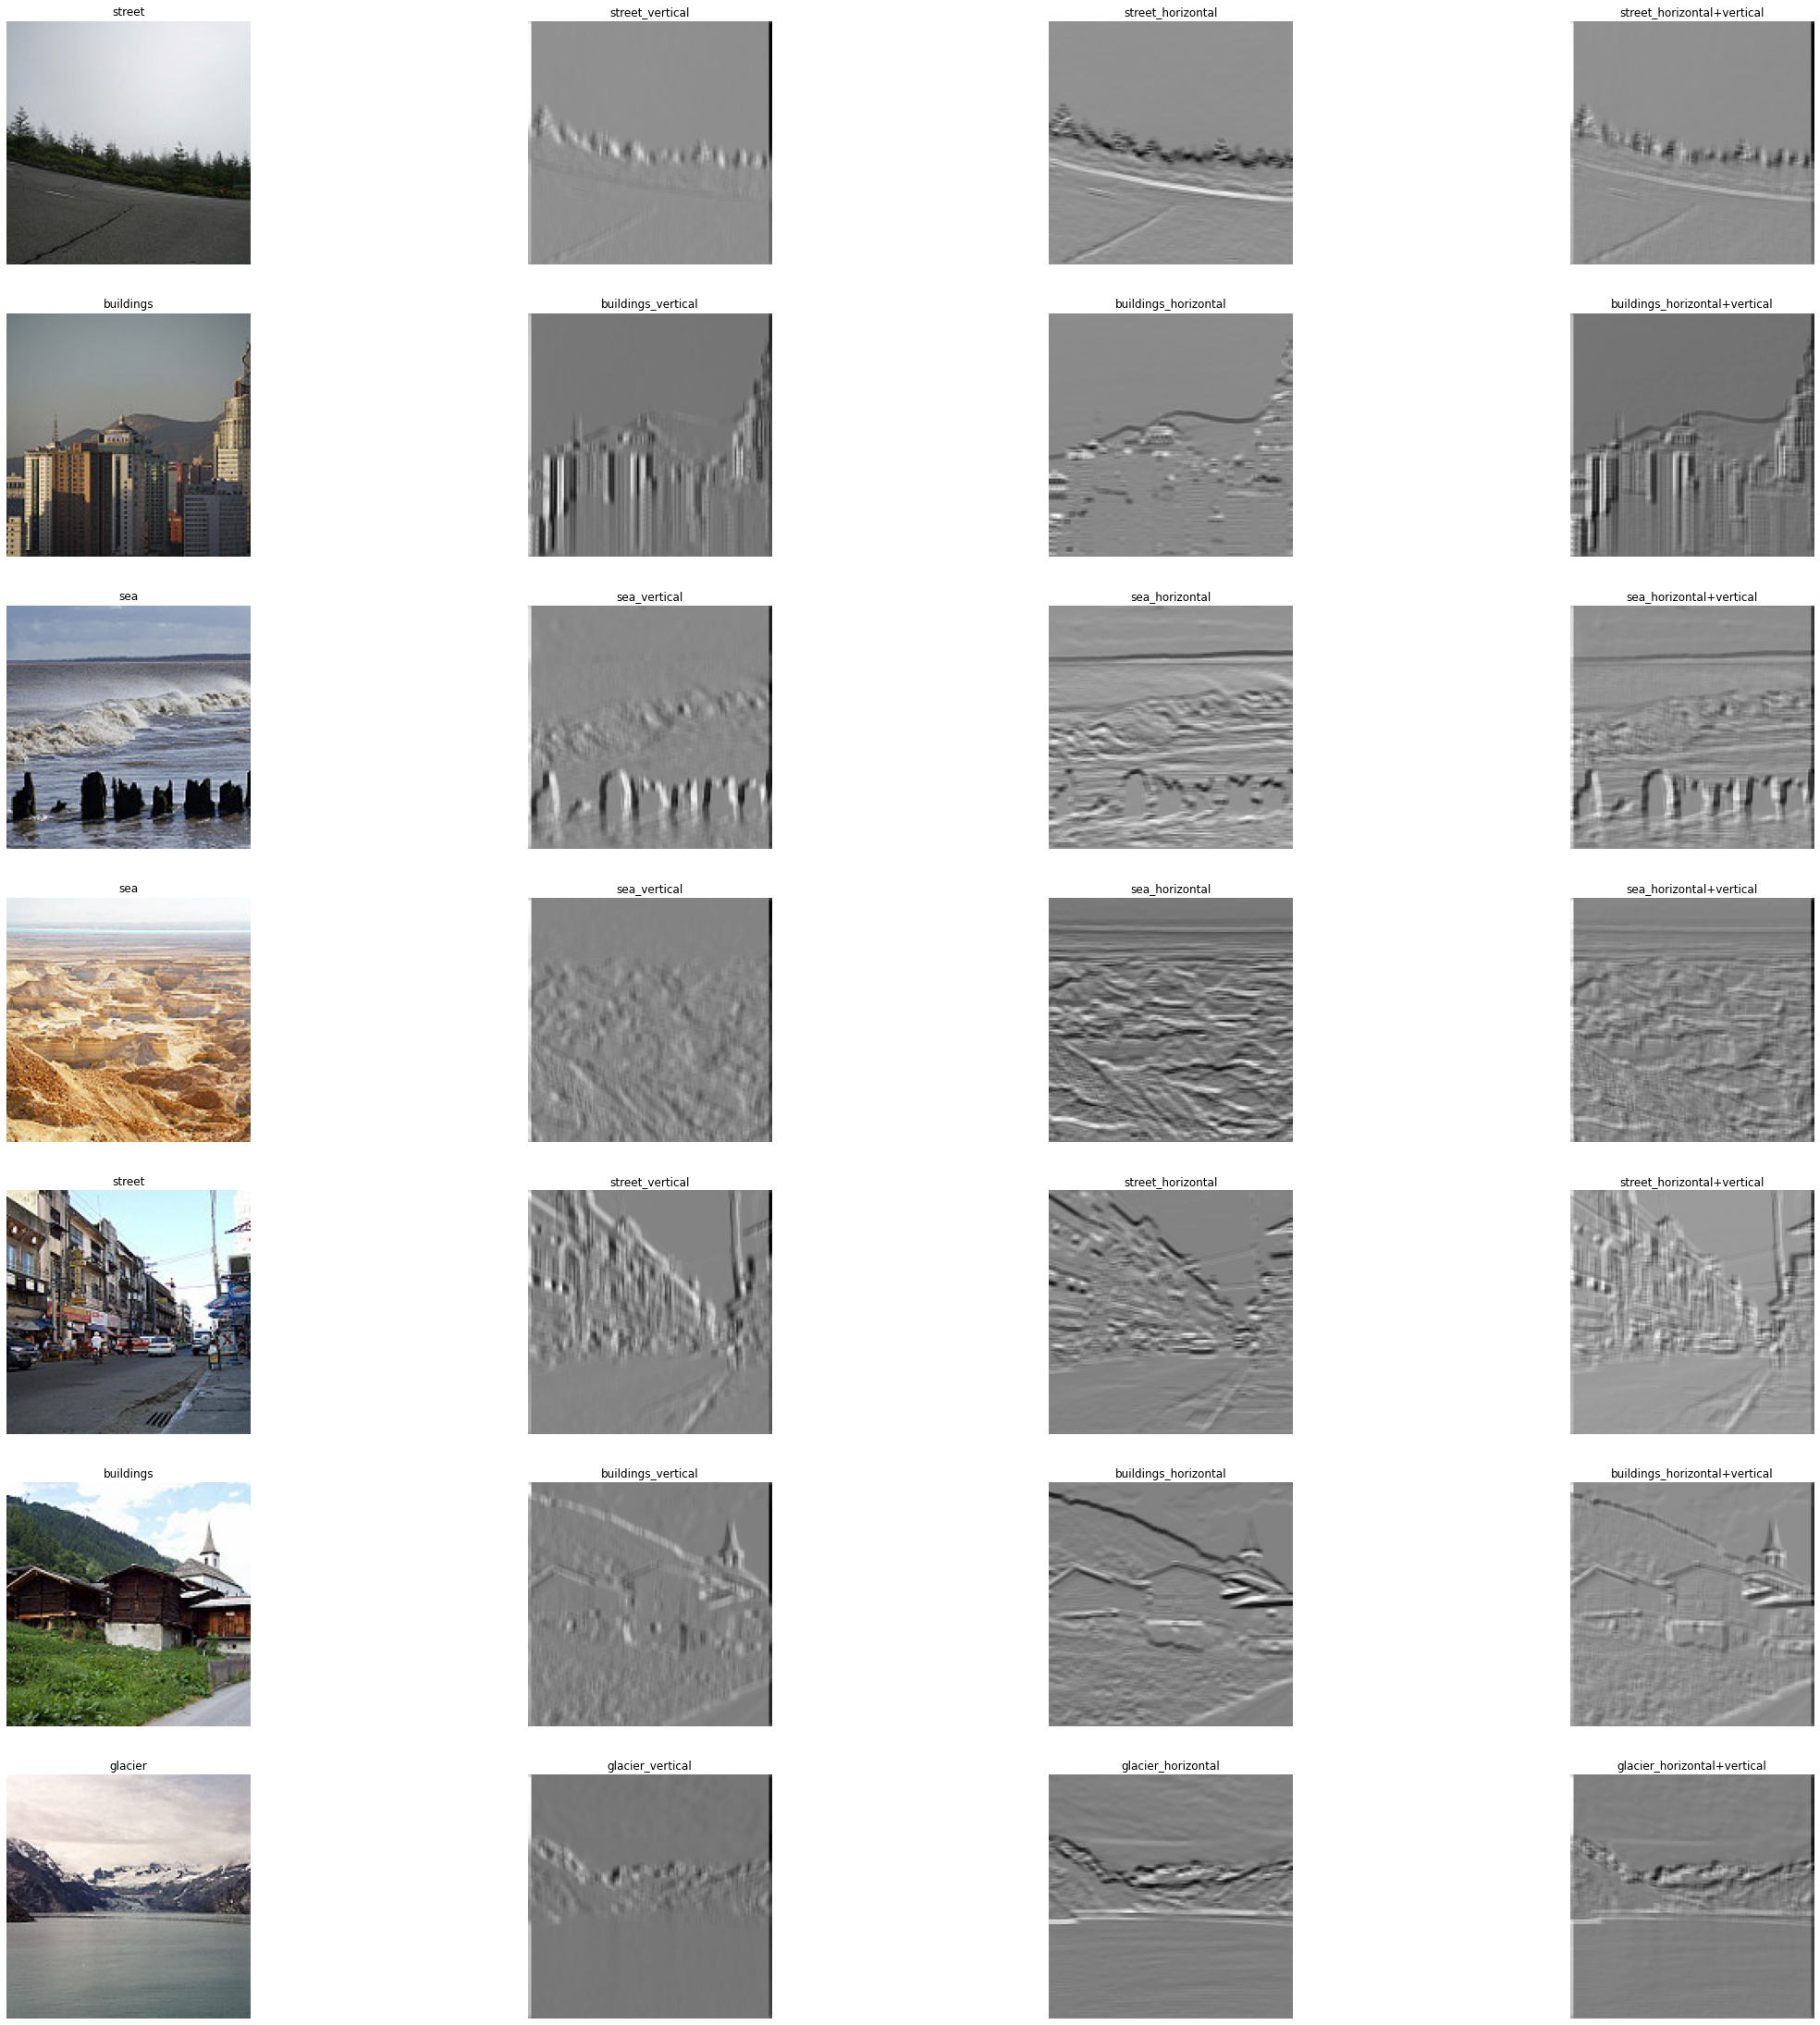

In [66]:
random.seed(10)

f,ax = plt.subplots(7,4) 
f.subplots_adjust(0,0,2,2)
f.set_figheight(15)
f.set_figwidth(15)
for i in range(0,7,1):
    rnd_number = randint(0,len(X_train))
    ax[i,0].imshow(X_train[rnd_number])
    ax[i,0].set_title(get_L(y_train[rnd_number]))
    ax[i,0].axis('off')
    
    check_edges_vert=get_vertical_features(X_train[rnd_number])
    ax[i,1].imshow(check_edges_vert, cmap="gray")
    ax[i,1].set_title(get_L(y_train[rnd_number])+"_vertical")
    ax[i,1].axis('off')
    check_edges_horz=get_horizontal_features(X_train[rnd_number])
    ax[i,2].imshow(check_edges_horz, cmap="gray")
    ax[i,2].set_title(get_L(y_train[rnd_number])+"_horizontal") 
    ax[i,2].axis('off')
    ax[i,3].imshow(check_edges_horz+check_edges_vert, cmap="gray")
    ax[i,3].set_title(get_L(y_train[rnd_number])+"_horizontal+vertical")
    ax[i,3].axis('off')

## baseline_model training

In [9]:
from keras.layers import Input, Dense, Conv2D, MaxPooling2D, UpSampling2D, Reshape, Concatenate, Flatten, Lambda
from keras.models import Model

def create_EC():
    input_img = Input(shape=(150, 150, 3))

    channels = 2
    x = input_img
    for i in range(4):
        channels *= 2
        x1=Conv2D(channels,(3,3),activation='relu', padding='same')(x)
        x2=Conv2D(channels,(2,2),activation='relu', padding='same')(x)
        c=Concatenate(axis=-1)([x1,x2])
        x=MaxPooling2D(padding='same')(c)
    x = Dense(channels)(x)
    x = Flatten()(x)
    x= Dense(64, activation='relu')(x)
    x= Dense(64, activation='relu')(x)
    prediction= Dense(6, activation='softmax')(x)
    model=Model(inputs=input_img,outputs=prediction)
    model.compile(optimizer='rmsprop',
              loss='categorical_crossentropy',
              metrics=['accuracy'])
    return model
base_model=create_EC()
base_model.summary()

Using TensorFlow backend.
/home/uhn61/anaconda3/envs/project4/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:526: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/uhn61/anaconda3/envs/project4/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:527: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/uhn61/anaconda3/envs/project4/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:528: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/home/uhn61/anaco

Instructions for updating:
Colocations handled automatically by placer.
Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 150, 150, 3)  0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 150, 150, 4)  112         input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_2 (Conv2D)               (None, 150, 150, 4)  52          input_1[0][0]                    
__________________________________________________________________________________________________
concatenate_1 (Concatenate)     (None, 150, 150, 8)  0           conv2d_1[0][0]                   
                    

In [10]:

random.seed(10)
filepath="baselinemodel.h5"
callback=ModelCheckpoint(filepath, monitor='val_loss', verbose=0, save_best_only=True, save_weights_only=False, mode='auto', period=1)
callbacks_list=[callback]
hist=base_model.fit(X_train, y_train,
                epochs=20,
                batch_size=128,
                shuffle=True,
                validation_data=(X_val, y_val),callbacks=callbacks_list)

Instructions for updating:
Use tf.cast instead.
Train on 9824 samples, validate on 4210 samples
Epoch 1/20
9824/9824 [==============================] - 76s 8ms/step - loss: 1.3177 - accuracy: 0.4755 - val_loss: 1.0046 - val_accuracy: 0.6048
Epoch 2/20
9824/9824 [==============================] - 77s 8ms/step - loss: 0.9957 - accuracy: 0.6233 - val_loss: 0.8875 - val_accuracy: 0.6620
Epoch 3/20
9824/9824 [==============================] - 76s 8ms/step - loss: 0.8572 - accuracy: 0.6745 - val_loss: 0.8412 - val_accuracy: 0.6779
Epoch 4/20
9824/9824 [==============================] - 77s 8ms/step - loss: 0.7689 - accuracy: 0.7119 - val_loss: 0.7860 - val_accuracy: 0.6988
Epoch 5/20
9824/9824 [==============================] - 77s 8ms/step - loss: 0.6784 - accuracy: 0.7496 - val_loss: 0.7439 - val_accuracy: 0.7259
Epoch 6/20
9824/9824 [==============================] - 77s 8ms/step - loss: 0.6169 - accuracy: 0.7744 - val_loss: 0.6887 - val_accuracy: 0.7451
Epoch 7/20
9824/9824 [============

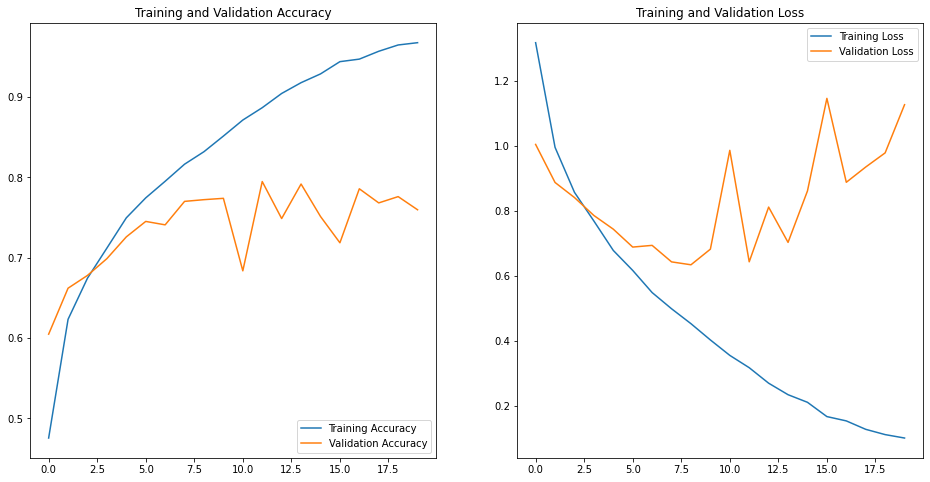

In [16]:
epochs=20
show_acc(hist) 

accuracy는 증가했지만, val_loss는 어느 순간을 기점으로 증가했다. 그 기준은 Epoch 9/20이 가장 적당해 보인다.
75s 8ms/step - loss: 0.4530 - accuracy: 0.8319 - val_loss: 0.6342 - val_accuracy: 0.7722

In [17]:
from keras.models import load_model
model=load_model(filepath)
results = model.evaluate(X_test, y_test, batch_size=128)
print("test loss, test acc:", results)

3000/3000 [==============================] - 13s 4ms/step
test loss, test acc: [0.634773359855016, 0.7763333320617676]


## preprocessing 한 데이터를 모델링 해보기

In [21]:
from keras.layers import Input, Dense, Conv2D, MaxPooling2D, UpSampling2D, Reshape, Concatenate, Flatten, Lambda
from keras.models import Model

def create_ECG():
    input_img = Input(shape=(150, 150, 1))

    channels = 2
    x = input_img
    for i in range(4):
        channels *= 2
        x1=Conv2D(channels,(3,3),activation='relu', padding='same')(x)
        x2=Conv2D(channels,(2,2),activation='relu', padding='same')(x)
        c=Concatenate(axis=-1)([x1,x2])
        x=MaxPooling2D(padding='same')(c)
    x = Dense(channels)(x)
    x = Flatten()(x)
    x= Dense(64, activation='relu')(x)
    x= Dense(64, activation='relu')(x)
    prediction= Dense(6, activation='softmax')(x)
    model=Model(inputs=input_img,outputs=prediction)
    model.compile(optimizer='rmsprop',
              loss='categorical_crossentropy',
              metrics=['accuracy'])
    return model
model=create_ECG()
model.summary()

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            (None, 150, 150, 1)  0                                            
__________________________________________________________________________________________________
conv2d_9 (Conv2D)               (None, 150, 150, 4)  40          input_2[0][0]                    
__________________________________________________________________________________________________
conv2d_10 (Conv2D)              (None, 150, 150, 4)  20          input_2[0][0]                    
__________________________________________________________________________________________________
concatenate_5 (Concatenate)     (None, 150, 150, 8)  0           conv2d_9[0][0]                   
                                                                 conv2d_10[0][0]            

In [20]:
def convert_data(func,X_data):
    X_changed=[]
    for x in X_data:
        i=func(x)
        X_changed.append(resize(i,(150,150,1)))
    return np.array(X_changed)
X_train_v=convert_data(get_vertical_features,X_train)
X_train_h=convert_data(get_horizontal_features,X_train)
X_val_v=convert_data(get_vertical_features,X_val)
X_val_h=convert_data(get_horizontal_features,X_val)


KeyboardInterrupt: 

In [ ]:
X_train_v.shape

In [21]:
###vertical feature만 가지고 모델 학습

In [29]:
model=create_ECG()
filepath="vertical_model.h5"
callback=ModelCheckpoint(filepath, monitor='val_loss', verbose=0, save_best_only=True, save_weights_only=False, mode='auto', period=1)
callbacks_list=[callback]
hist=model.fit(X_train_v, y_train,
                epochs=20,
                batch_size=128,
                shuffle=True,
                validation_data=(X_val_v, y_val),callbacks=callbacks_list)

Train on 9824 samples, validate on 4210 samples
Epoch 1/20
9824/9824 [==============================] - 68s 7ms/step - loss: 1.2341 - accuracy: 0.5016 - val_loss: 1.0079 - val_accuracy: 0.5990
Epoch 2/20
9824/9824 [==============================] - 71s 7ms/step - loss: 0.9097 - accuracy: 0.6548 - val_loss: 0.8675 - val_accuracy: 0.6615
Epoch 3/20
9824/9824 [==============================] - 73s 7ms/step - loss: 0.7830 - accuracy: 0.7025 - val_loss: 0.8888 - val_accuracy: 0.6527
Epoch 4/20
9824/9824 [==============================] - 73s 7ms/step - loss: 0.6965 - accuracy: 0.7294 - val_loss: 0.8641 - val_accuracy: 0.6622
Epoch 5/20
9824/9824 [==============================] - 75s 8ms/step - loss: 0.6106 - accuracy: 0.7661 - val_loss: 0.7797 - val_accuracy: 0.7059
Epoch 6/20
9824/9824 [==============================] - 74s 8ms/step - loss: 0.5368 - accuracy: 0.7967 - val_loss: 0.7818 - val_accuracy: 0.7185
Epoch 7/20
9824/9824 [==============================] - 74s 8ms/step - loss: 0.461

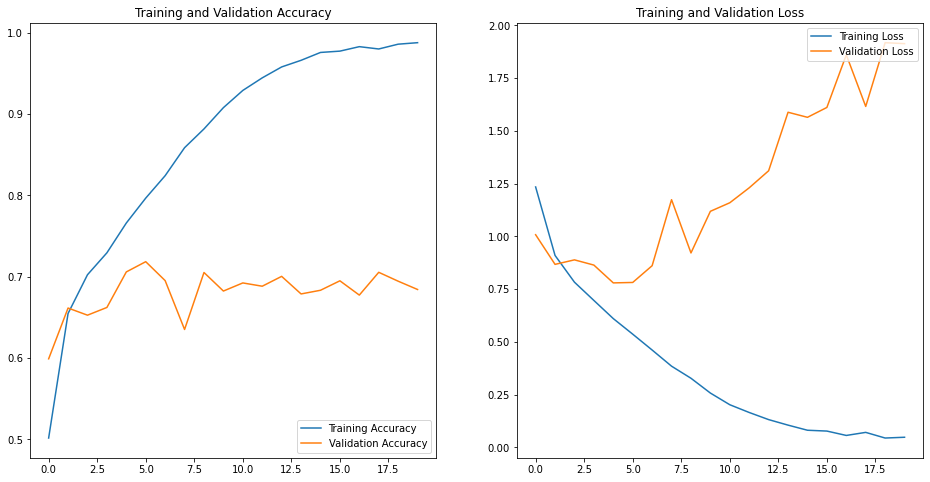

In [30]:
epochs=20
show_acc(hist) 

In [ ]:
###horizontal feature만 가지고 모델 학습

In [31]:
model=create_ECG()
filepath="horizontal_model.h5"
callback=ModelCheckpoint(filepath, monitor='val_loss', verbose=0, save_best_only=True, save_weights_only=False, mode='auto', period=1)
callbacks_list=[callback]
hist=model.fit(X_train_h, y_train,
                epochs=20,
                batch_size=128,
                shuffle=True,
                validation_data=(X_val_h, y_val),callbacks=callbacks_list)

Train on 9824 samples, validate on 4210 samples
Epoch 1/20
9824/9824 [==============================] - 77s 8ms/step - loss: 1.4472 - accuracy: 0.4436 - val_loss: 1.1352 - val_accuracy: 0.5684
Epoch 2/20
9824/9824 [==============================] - 70s 7ms/step - loss: 1.0399 - accuracy: 0.6213 - val_loss: 0.9221 - val_accuracy: 0.6537
Epoch 3/20
9824/9824 [==============================] - 67s 7ms/step - loss: 0.8696 - accuracy: 0.6878 - val_loss: 0.8483 - val_accuracy: 0.6919
Epoch 4/20
9824/9824 [==============================] - 70s 7ms/step - loss: 0.7359 - accuracy: 0.7372 - val_loss: 0.8111 - val_accuracy: 0.7157
Epoch 5/20
9824/9824 [==============================] - 64s 7ms/step - loss: 0.6465 - accuracy: 0.7707 - val_loss: 0.9045 - val_accuracy: 0.6922
Epoch 6/20
9824/9824 [==============================] - 64s 7ms/step - loss: 0.5693 - accuracy: 0.7986 - val_loss: 0.8431 - val_accuracy: 0.7059
Epoch 7/20
9824/9824 [==============================] - 70s 7ms/step - loss: 0.487

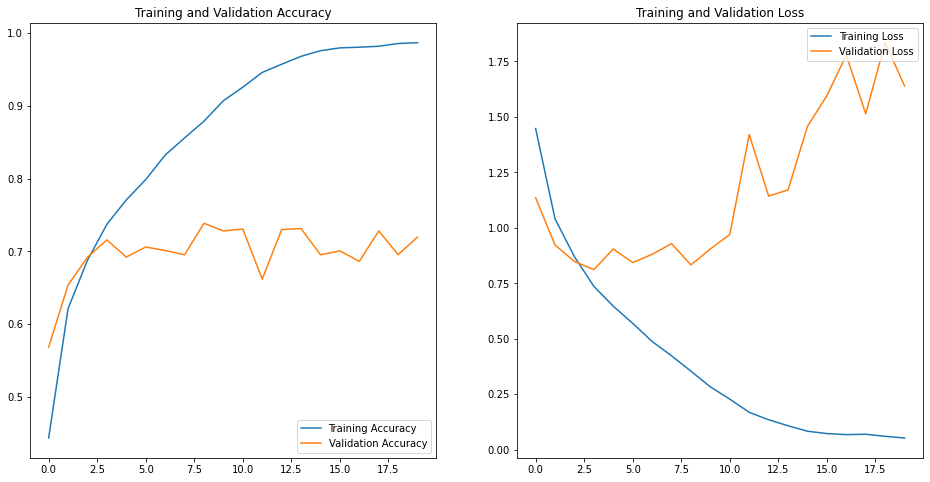

In [32]:
epochs=20
show_acc(hist) 

In [ ]:
###grid feature만 가지고 모델 학습

In [33]:
model=create_ECG()
filepath="grid_model.h5"
callback=ModelCheckpoint(filepath, monitor='val_loss', verbose=0, save_best_only=True, save_weights_only=False, mode='auto', period=1)
callbacks_list=[callback]
hist=model.fit(X_train_h+X_train_v, y_train,
                epochs=20,
                batch_size=128,
                shuffle=True,
                validation_data=(X_val_v+X_val_h, y_val),callbacks=callbacks_list)

Train on 9824 samples, validate on 4210 samples
Epoch 1/20
9824/9824 [==============================] - 70s 7ms/step - loss: 1.3154 - accuracy: 0.4699 - val_loss: 0.9693 - val_accuracy: 0.6190
Epoch 2/20
9824/9824 [==============================] - 56s 6ms/step - loss: 0.9382 - accuracy: 0.6393 - val_loss: 0.9343 - val_accuracy: 0.6496
Epoch 3/20
9824/9824 [==============================] - 57s 6ms/step - loss: 0.8015 - accuracy: 0.7001 - val_loss: 1.0105 - val_accuracy: 0.6081
Epoch 4/20
9824/9824 [==============================] - 53s 5ms/step - loss: 0.6976 - accuracy: 0.7410 - val_loss: 0.8414 - val_accuracy: 0.6748
Epoch 5/20
9824/9824 [==============================] - 54s 6ms/step - loss: 0.5926 - accuracy: 0.7796 - val_loss: 0.7797 - val_accuracy: 0.7114
Epoch 6/20
9824/9824 [==============================] - 57s 6ms/step - loss: 0.5108 - accuracy: 0.8123 - val_loss: 0.8109 - val_accuracy: 0.7173
Epoch 7/20
9824/9824 [==============================] - 56s 6ms/step - loss: 0.430

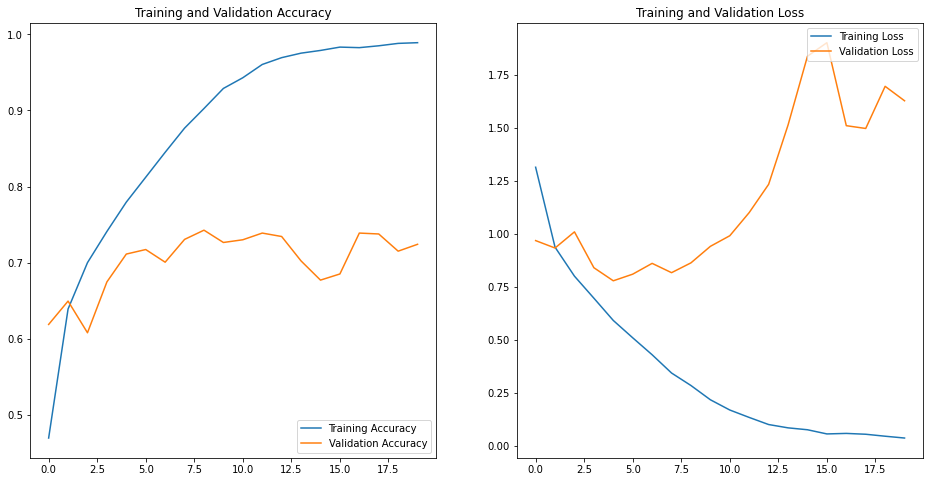

In [34]:
epochs=20
show_acc(hist) 

In [ ]:
### binary로 변환한 뒤 모델 학습

In [ ]:
####1. ADAPTIVE_THRESH_MEAN

In [67]:
def clr2bin_MEAN(x,a):
    x_grayscale=color.rgb2gray(x)
    x_grayscale=x_grayscale*255
    x_grayscale=x_grayscale.astype('uint8')
    i=cv2.adaptiveThreshold(x_grayscale,255,cv2.ADAPTIVE_THRESH_MEAN_C,cv2.THRESH_BINARY,a,2)
    return resize(i,(150,150,1))

def clr2bin_GAUSSIAN(x,a):
    x_grayscale=color.rgb2gray(x)
    x_grayscale=x_grayscale*255
    x_grayscale=x_grayscale.astype('uint8')
    i=cv2.adaptiveThreshold(x_grayscale,255,cv2.ADAPTIVE_THRESH_GAUSSIAN_C,cv2.THRESH_BINARY,a,2)
    return resize(i,(150,150,1))

def convert_bin(X_data,a,func):
    X_convert=[]
    for x in X_data:
        X_convert.append(func(x,a))
    return np.array(X_convert)


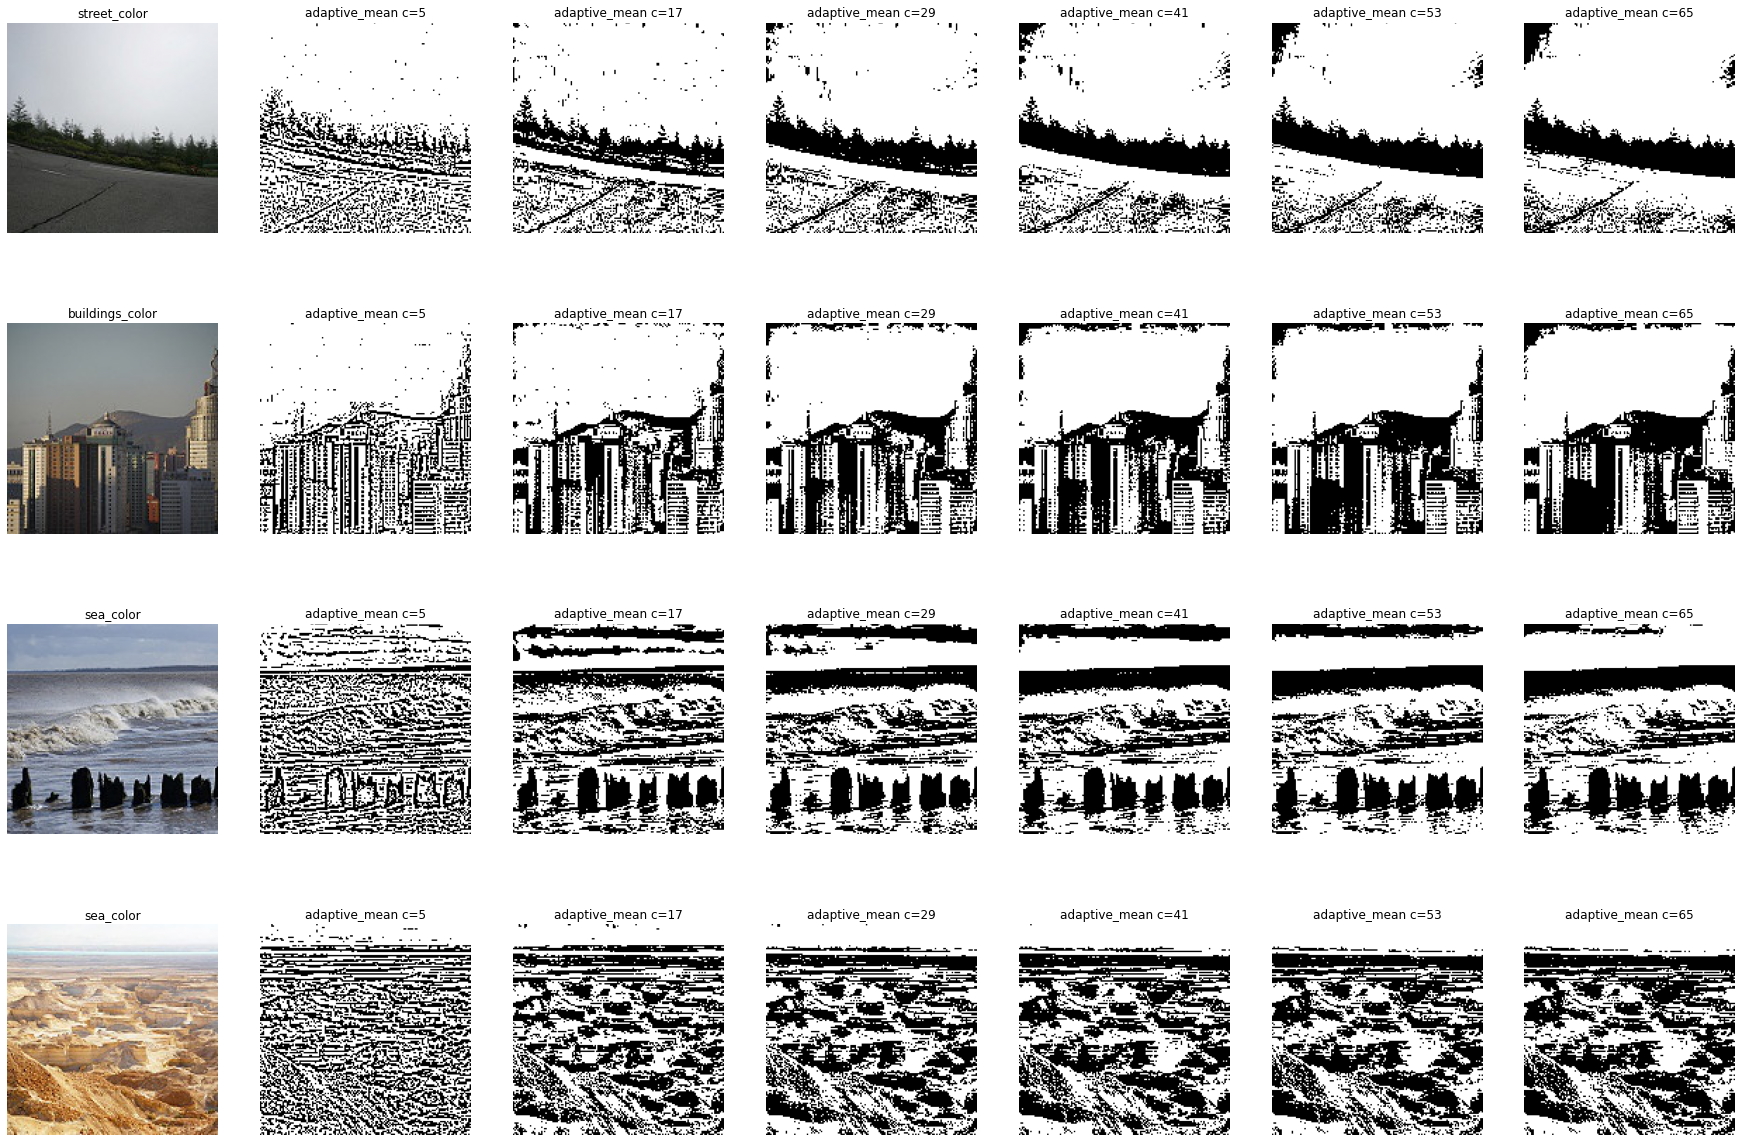

In [13]:
random.seed(10)

f,ax = plt.subplots(4,7) 
f.subplots_adjust(0,0,4,4)
for i in range(0,4,1):
    rnd_number = randint(0,len(X_train))
    ax[i,0].imshow(X_train[rnd_number])
    ax[i,0].set_title(get_L(y_train[rnd_number])+"_color")
    ax[i,0].axis('off')
    for j in range(1,7,1):
        x=j*12-7
        ax[i,j].imshow(clr2bin_MEAN(X_train[rnd_number],x), cmap="gray")
        ax[i,j].set_title("""adaptive_mean c={}""".format(x))
        ax[i,j].axis('off')
    


In [ ]:
####2. ADAPTIVE_THRESH_GAUSSIAN

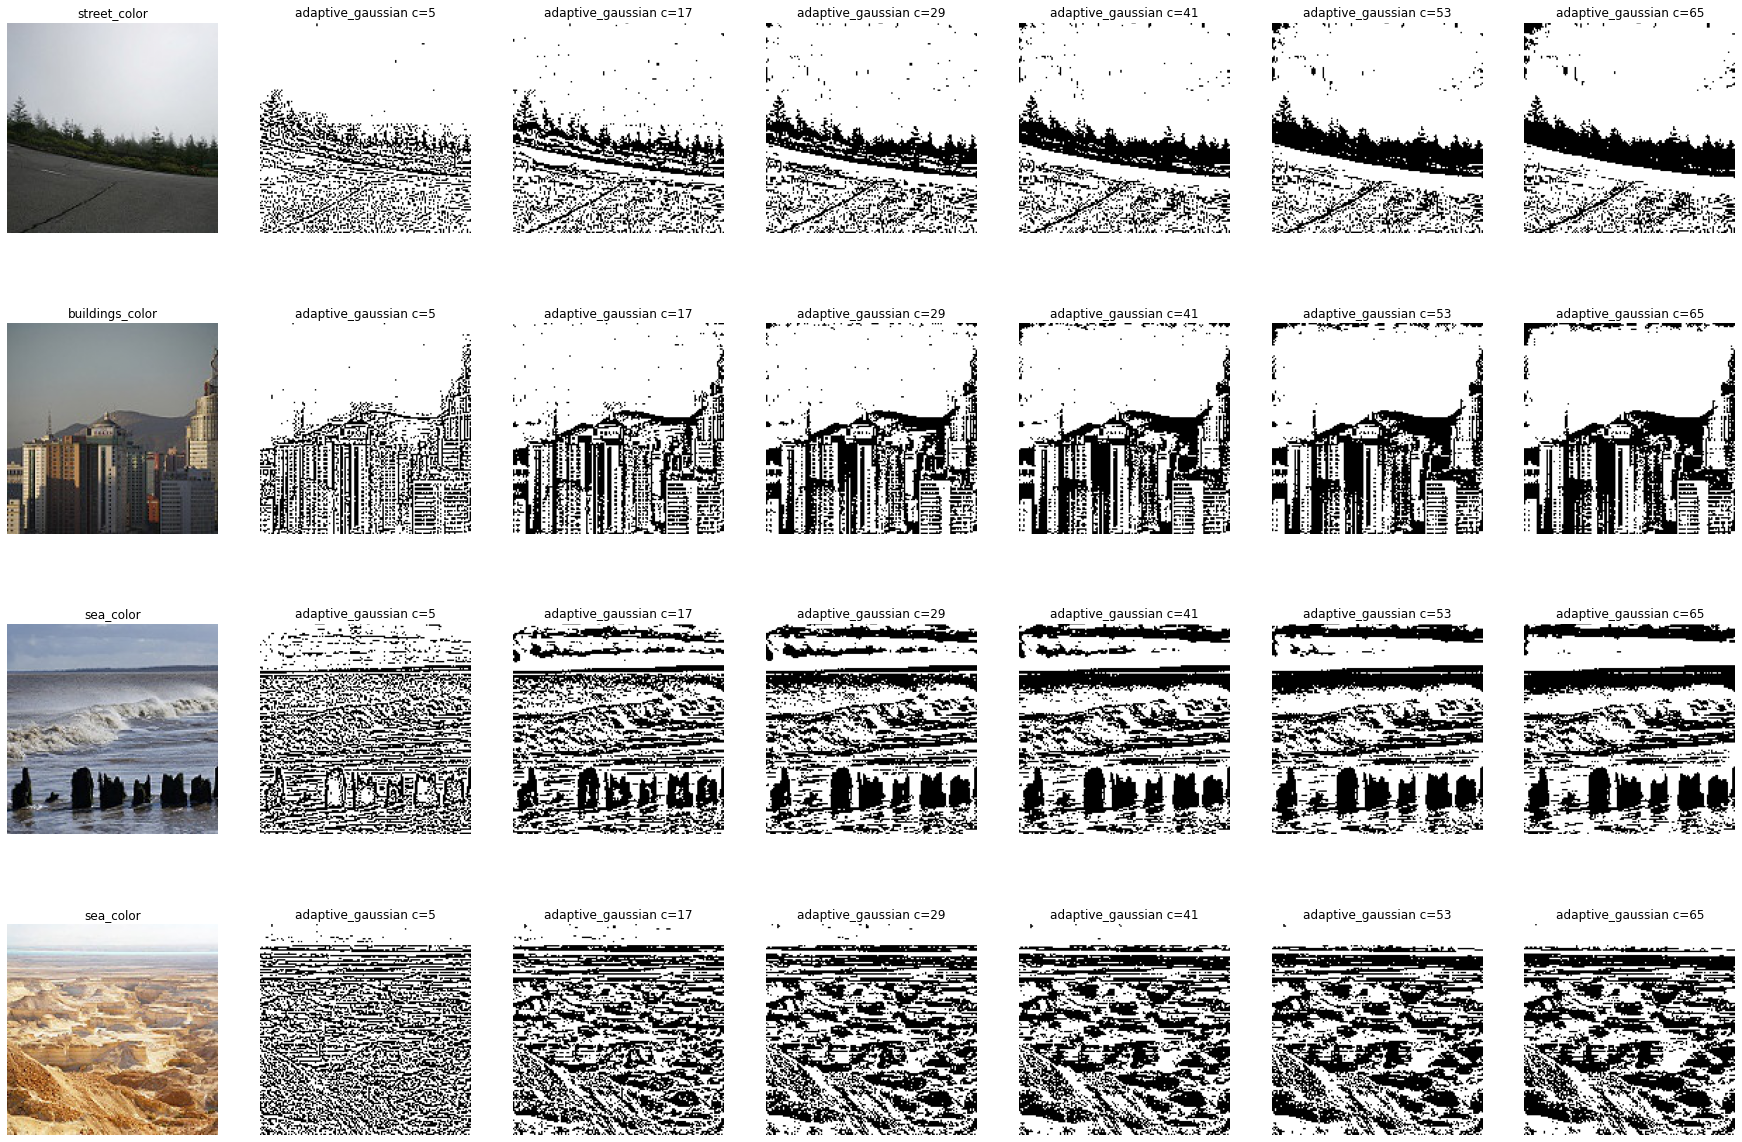

In [68]:
random.seed(10)

f,ax = plt.subplots(4,7) 
f.subplots_adjust(0,0,4,4)
for i in range(0,4,1):
    rnd_number = randint(0,len(X_train))
    ax[i,0].imshow(X_train[rnd_number])
    ax[i,0].set_title(get_L(y_train[rnd_number])+"_color")
    ax[i,0].axis('off')
    for j in range(1,7,1):
        x=j*12-7
        ax[i,j].imshow(clr2bin_GAUSSIAN(X_train[rnd_number],x), cmap="gray")
        ax[i,j].set_title("""adaptive_gaussian c={}""".format(x))
        ax[i,j].axis('off')

In [25]:
c_list=[5,31,65]
hist_m=[]
for c in c_list : 
    model=create_ECG()
    X_train_g=convert_bin(X_train,c,clr2bin_MEAN)   
    X_val_g=convert_bin(X_val,c,clr2bin_MEAN)   
    filepath="""model_mean_{}.h5""".format(c)
    callback=ModelCheckpoint(filepath, monitor='val_loss', verbose=0, save_best_only=True, save_weights_only=False, mode='auto', period=1)
    callbacks_list=[callback]
    hist=model.fit(X_train_g, y_train,
                epochs=20,
                batch_size=128,
                shuffle=True,
                validation_data=(X_val_g, y_val),callbacks=callbacks_list)
    hist_m.append(hist)

Instructions for updating:
Use tf.cast instead.
Train on 9824 samples, validate on 4210 samples
Epoch 1/20
9824/9824 [==============================] - 72s 7ms/step - loss: 1.5530 - accuracy: 0.3518 - val_loss: 1.0913 - val_accuracy: 0.5974
Epoch 2/20
9824/9824 [==============================] - 72s 7ms/step - loss: 1.1538 - accuracy: 0.5508 - val_loss: 0.9306 - val_accuracy: 0.6306
Epoch 3/20
9824/9824 [==============================] - 75s 8ms/step - loss: 1.0129 - accuracy: 0.6100 - val_loss: 0.9122 - val_accuracy: 0.6475
Epoch 4/20
9824/9824 [==============================] - 74s 8ms/step - loss: 0.9105 - accuracy: 0.6474 - val_loss: 0.9139 - val_accuracy: 0.6359
Epoch 5/20
9824/9824 [==============================] - 75s 8ms/step - loss: 0.8149 - accuracy: 0.6832 - val_loss: 0.9504 - val_accuracy: 0.6344
Epoch 6/20
9824/9824 [==============================] - 75s 8ms/step - loss: 0.7712 - accuracy: 0.7000 - val_loss: 0.8104 - val_accuracy: 0.6774
Epoch 7/20
9824/9824 [============

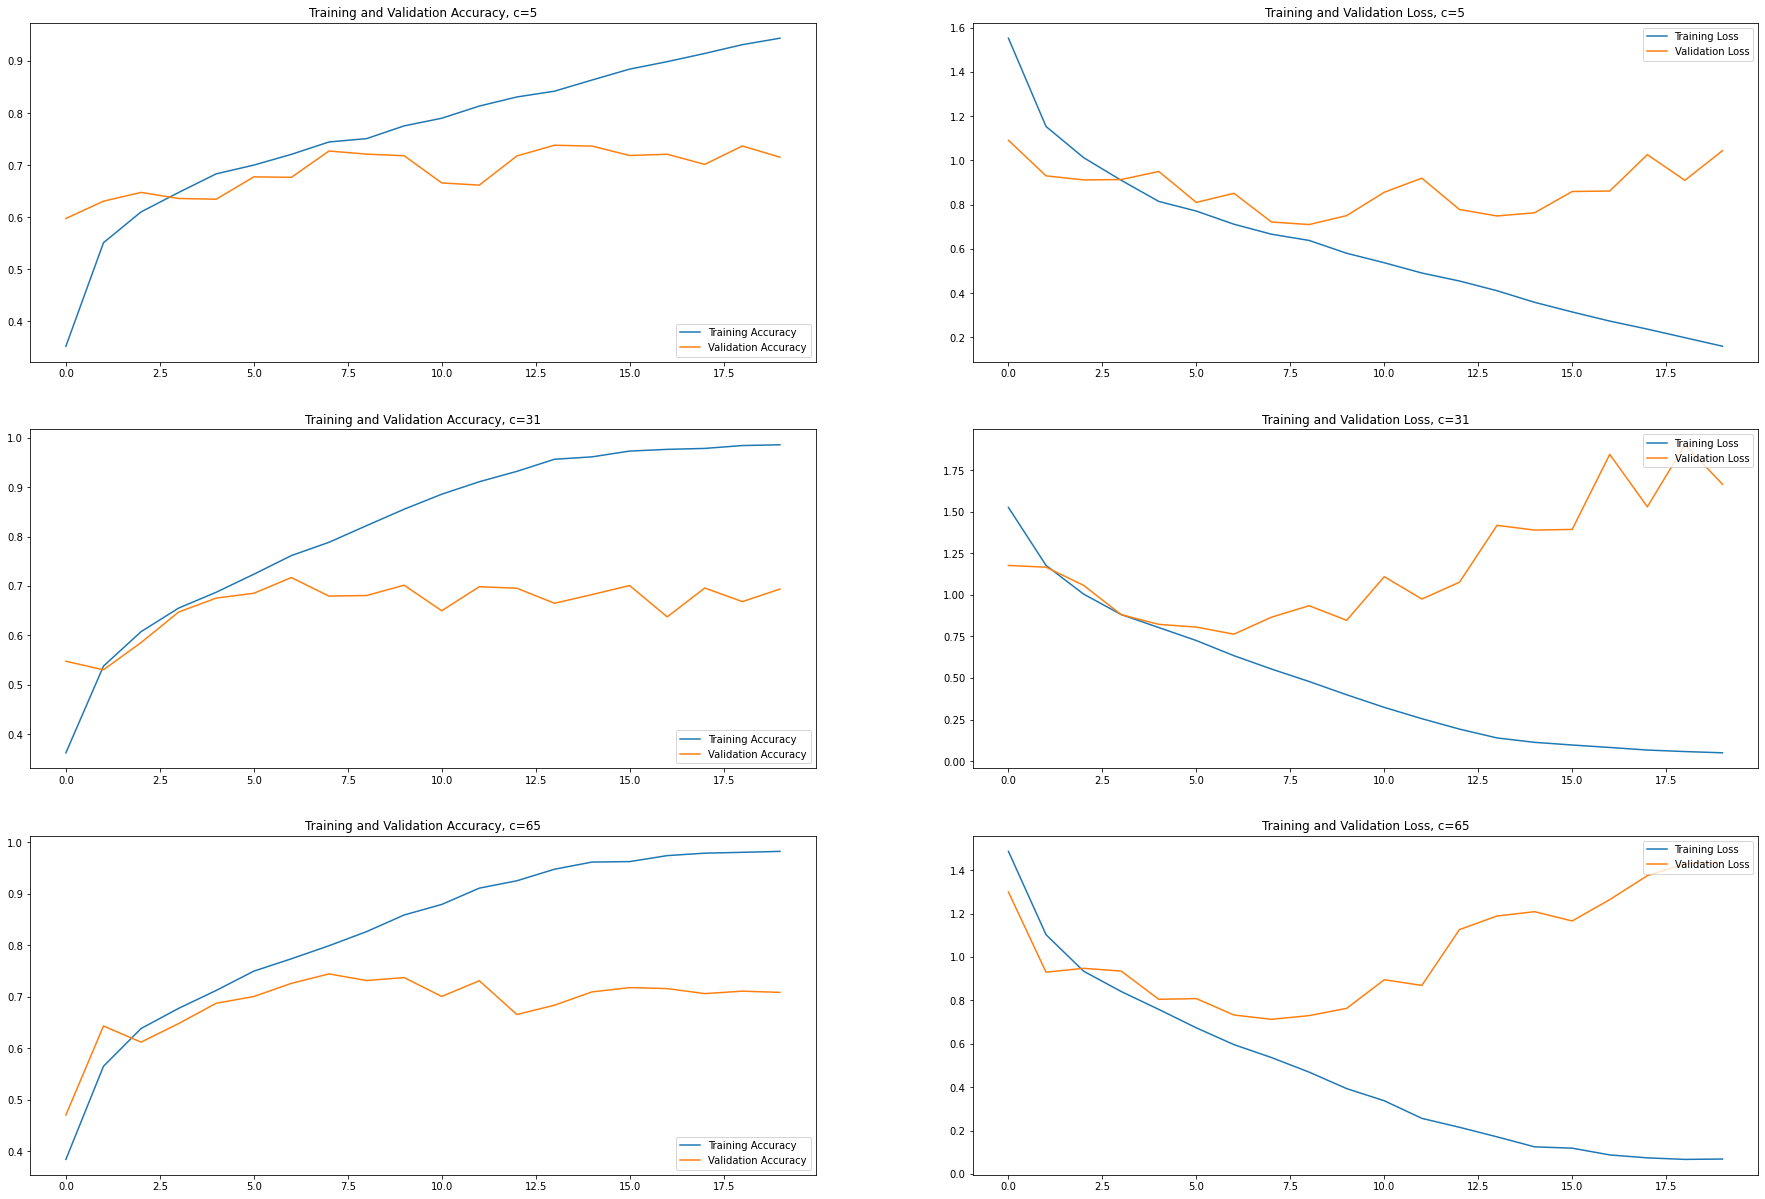

In [33]:



def show_acc_mul(history):
    c_list=[5,31,65]
    f,ax = plt.subplots(3,2)
    f.subplots_adjust(0,0,4,4)
    for i,hist in enumerate(history):
        acc = hist.history['accuracy']
        val_acc = hist.history['val_accuracy']

        loss = hist.history['loss']
        val_loss = hist.history['val_loss']

        epochs_range = range(epochs)

        ax[i,0].plot(epochs_range, acc, label='Training Accuracy')
        ax[i,0].plot(epochs_range, val_acc, label='Validation Accuracy')
        ax[i,0].legend(loc='lower right')
        ax[i,0].set_title("""Training and Validation Accuracy, c={}""".format(c_list[i]))

        ax[i,1].plot(epochs_range, loss, label='Training Loss')
        ax[i,1].plot(epochs_range, val_loss, label='Validation Loss')
        ax[i,1].legend(loc='upper right')
        ax[i,1].set_title("""Training and Validation Loss, c={}""".format(c_list[i]))
    plt.show()
    
epochs=20
show_acc_mul(hist_m)

In [69]:
c_list=[5,31,65]
hist_g=[]
for c in c_list : 
    model=create_ECG()
    X_train_g=convert_bin(X_train,c,clr2bin_GAUSSIAN) 
    X_val_g=convert_bin(X_val,c,clr2bin_GAUSSIAN)   
    filepath="""model_gaussian_{}.h5""".format(c)
    callback=ModelCheckpoint(filepath, monitor='val_loss', verbose=0, save_best_only=True, save_weights_only=False, mode='auto', period=1)
    callbacks_list=[callback]
    hist=model.fit(X_train_g, y_train,
                epochs=20,
                batch_size=128,
                shuffle=True,
                validation_data=(X_val_g, y_val),callbacks=callbacks_list)
    hist_g.append(hist)

Train on 9824 samples, validate on 4210 samples
Epoch 1/20
9824/9824 [==============================] - 84s 9ms/step - loss: 1.5070 - accuracy: 0.3797 - val_loss: 1.0835 - val_accuracy: 0.5774
Epoch 2/20
9824/9824 [==============================] - 98s 10ms/step - loss: 1.1241 - accuracy: 0.5566 - val_loss: 1.0855 - val_accuracy: 0.5675
Epoch 3/20
9824/9824 [==============================] - 183s 19ms/step - loss: 0.9704 - accuracy: 0.6220 - val_loss: 0.7909 - val_accuracy: 0.6955
Epoch 4/20
9824/9824 [==============================] - 140s 14ms/step - loss: 0.8814 - accuracy: 0.6584 - val_loss: 0.7460 - val_accuracy: 0.7178
Epoch 5/20
9824/9824 [==============================] - 71s 7ms/step - loss: 0.7825 - accuracy: 0.6981 - val_loss: 0.9113 - val_accuracy: 0.6318
Epoch 6/20
9824/9824 [==============================] - 67s 7ms/step - loss: 0.7158 - accuracy: 0.7237 - val_loss: 0.6681 - val_accuracy: 0.7473
Epoch 7/20
9824/9824 [==============================] - 70s 7ms/step - loss: 

MemoryError: Unable to allocate 1.65 GiB for an array with shape (9824, 150, 150, 1) and data type float64

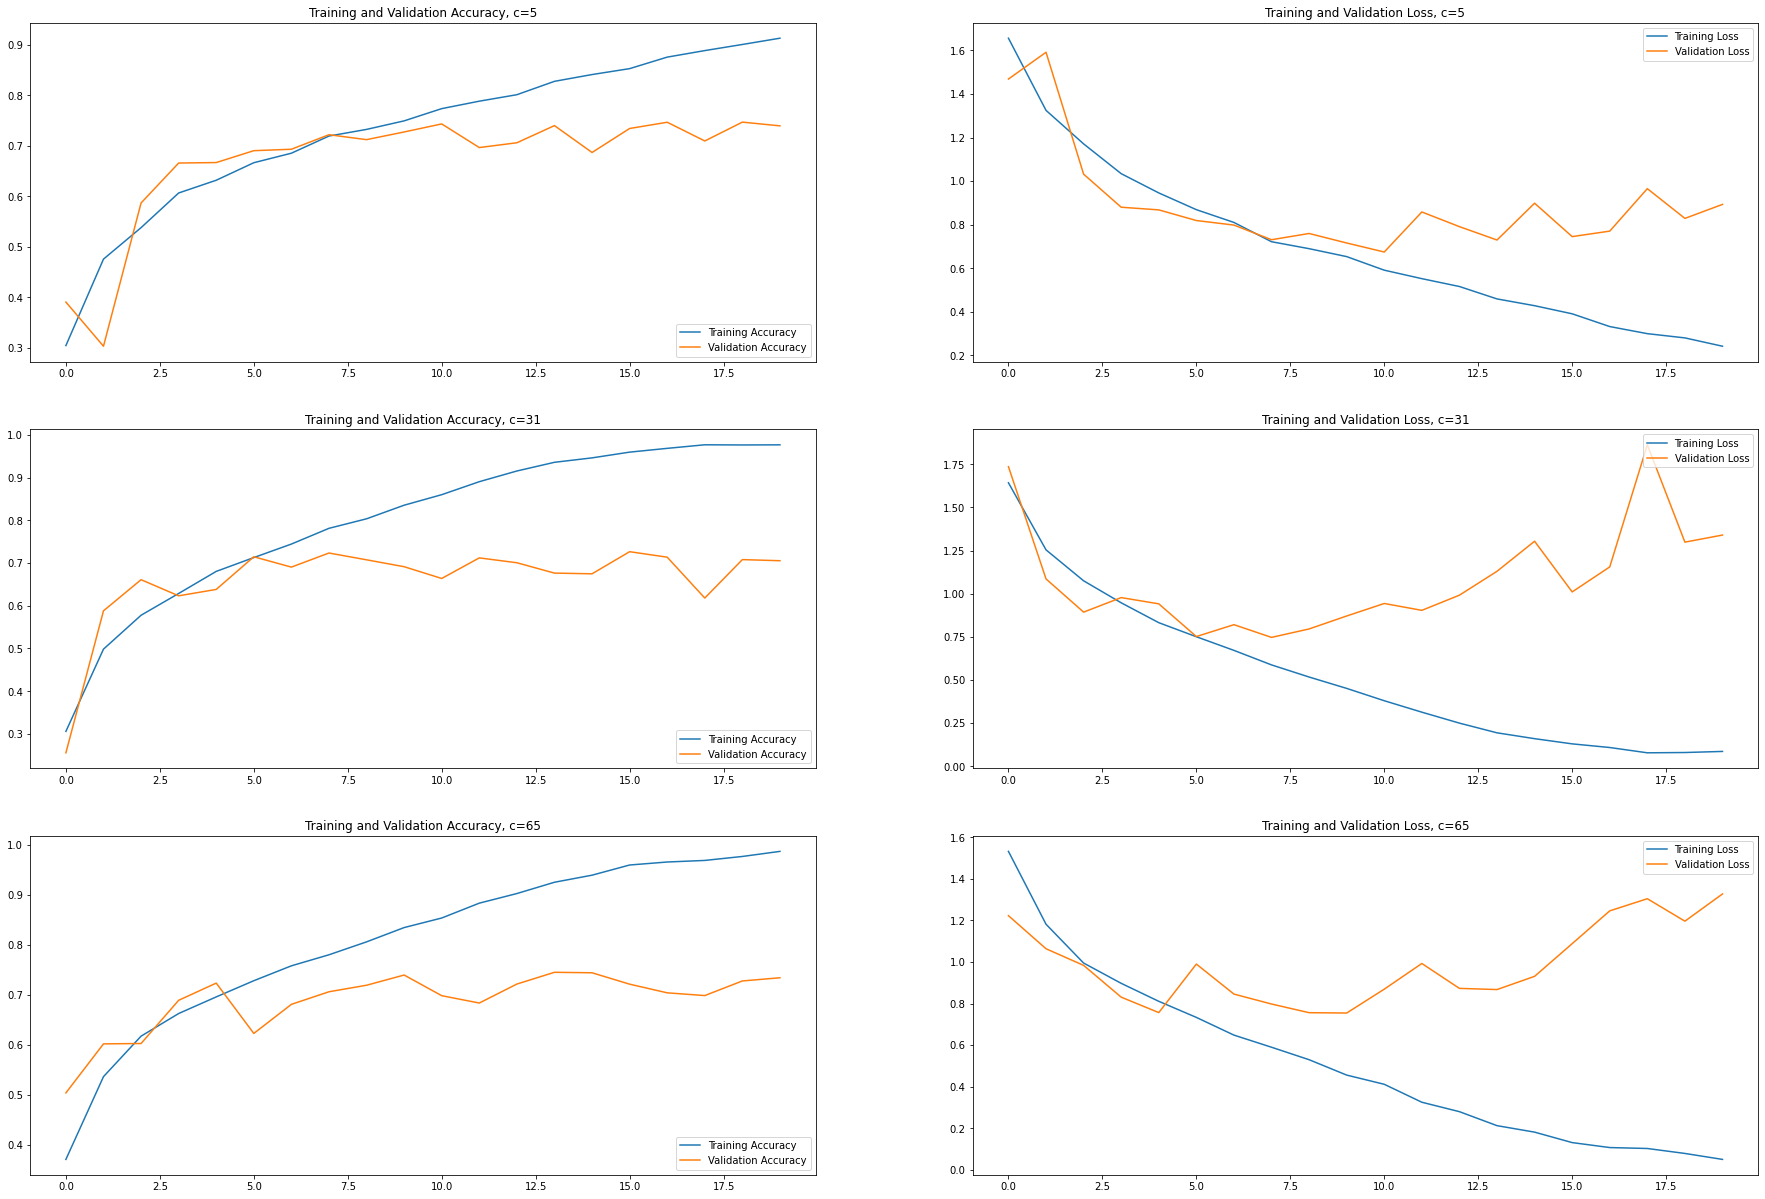

In [45]:
epochs=20
show_acc_mul(hist_g)

In [50]:
md='baselinemodel.h5'
model=load_model(md)
results = model.evaluate(X_test, y_test, batch_size=128)
print("""model: {} test loss, test acc: {}""".format(md,results))

3000/3000 [==============================] - 10s 3ms/step
model: baselinemodel.h5 test loss, test acc: [0.634773359855016, 0.7763333320617676]


In [48]:
def convert_data(func,X_data):
    X_changed=[]
    for x in X_data:
        i=func(x)
        X_changed.append(resize(i,(150,150,1)))
    return np.array(X_changed)
X_test_v=convert_data(get_vertical_features,X_test)
X_test_h=convert_data(get_horizontal_features,X_test)

In [51]:
md='horizontal_model.h5'
model=load_model(md)
results = model.evaluate(X_test_h, y_test, batch_size=128)
print("""model: {} test loss, test acc: {}""".format(md,results))

3000/3000 [==============================] - 13s 4ms/step
model: horizontal_model.h5 test loss, test acc: [0.7999722092946371, 0.7133333086967468]


In [52]:
md='vertical_model.h5'
model=load_model(md)
results = model.evaluate(X_test_v, y_test, batch_size=128)
print("""model: {} test loss, test acc: {}""".format(md,results))

3000/3000 [==============================] - 9s 3ms/step
model: vertical_model.h5 test loss, test acc: [0.7620102472305298, 0.715666651725769]


In [53]:
md='grid_model.h5'
model=load_model(md)
results = model.evaluate(X_test_h+X_test_v, y_test, batch_size=128)
print("""model: {} test loss, test acc: {}""".format(md,results))

3000/3000 [==============================] - 8s 3ms/step
model: grid_model.h5 test loss, test acc: [0.7611293346087138, 0.7059999704360962]


In [59]:
from keras.models import load_model
model_list=['model_mean_5.h5','model_mean_31.h5','model_mean_65.h5']
for c,md in zip(c_list,model_list):
    X_test_e=convert_bin(X_test,c,clr2bin_MEAN) 
    model=load_model(md)
    results = model.evaluate(X_test_e, y_test, batch_size=128)
    print("""model: {} test loss, test acc: {}""".format(md,results))

3000/3000 [==============================] - 9s 3ms/step
model: model_mean_5.h5 test loss, test acc: [0.7161927474339803, 0.7239999771118164]
3000/3000 [==============================] - 8s 3ms/step
model: model_mean_31.h5 test loss, test acc: [0.7718882913589478, 0.7176666855812073]
3000/3000 [==============================] - 11s 4ms/step
model: model_mean_65.h5 test loss, test acc: [0.7232322945594788, 0.7316666841506958]


In [61]:
model_list=['model_gaussian_5.h5','model_gaussian_31.h5','model_gaussian_65.h5']
for c,md in zip(c_list,model_list):
    X_test_e=convert_bin(X_test,c,clr2bin_GAUSSIAN) 
    model=load_model(md)
    results = model.evaluate(X_test_e, y_test, batch_size=128)
    print("""model: {} test loss, test acc: {}""".format(md,results))

3000/3000 [==============================] - 8s 3ms/step
model: model_gaussian_5.h5 test loss, test acc: [0.7058794659773509, 0.7406666874885559]
3000/3000 [==============================] - 8s 3ms/step
model: model_gaussian_31.h5 test loss, test acc: [0.7450712909698486, 0.7326666712760925]
3000/3000 [==============================] - 8s 3ms/step
model: model_gaussian_65.h5 test loss, test acc: [0.7812622388203939, 0.7296666502952576]
